In [3]:
# U-Net for Image Segmentation

This notebook illustrates how to build a [UNet](https://arxiv.org/abs/1505.04597) for semantic image segmentation. This architecture is also a fully convolutional network and is similar to the model you just built in the previous lesson. A key difference is the use of skip connections from the encoder to the decoder. You will see how this is implemented later as you build each part of the network.

At the end of this lab, you will be able to use the UNet to output segmentation masks that shows which pixels of an input image are part of the background, foreground, and outline.

<img src='https://drive.google.com/uc?export=view&id=1w8up90xVOYRT8vs5lNo2kEiVhm-7hWxZ' alt='sample_output'>

SyntaxError: invalid syntax (3027732861.py, line 3)

In [15]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

## Download the Oxford-IIIT Pets dataset

You will be training the model on the [Oxford Pets - IIT dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset. This contains pet images, their classes, segmentation masks and head region-of-interest. You will only use the images and segmentation masks in this lab.

This dataset is already included in TensorFlow Datasets and you can simply download it. The segmentation masks are included in versions 3 and above. The cell below will download the dataset and place the results in a dictionary named `dataset`. It will also collect information about the dataset and we'll assign it to a variable named `info`.

In [ ]:
# If you hit a problem with checksums, you can execute the following line first
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

# download the dataset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Let's briefly examine the contents of the dataset you just downloaded.

In [16]:
# see the possible keys we can access in the dataset dict.
# this contains the test and train splits.
print(dataset.keys())

dict_keys(['train', 'test'])


In [17]:
# see information about the dataset
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpsv77dcnstfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

## Prepare the Dataset

You will now prepare the train and test sets. The following utility functions preprocess the data. These include:

* simple augmentation by flipping the image
* normalizing the pixel values  
* resizing the images

Another preprocessing step is to adjust the segmentation mask's pixel values. The `README` in the [annotations](https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz) folder of the dataset mentions that the pixels in the segmentation mask are labeled as such:

| Label            | Class Name     |
| -------------    | -------------  |
| 1                | foreground     |
| 2                | background     |
| 3                | Not Classified |

<br>
<br>

For convenience, let's subtract `1` from these values and we will interpret these as `{'pet', 'background', 'outline'}`:

| Label            | Class Name     |
| -------------    | -------------  |
| 0                | pet            |
| 1                | background     |
| 2                | outline        |

# Preprocessing 

In [25]:
class Preproccessing:

    '''
    def __init__(self, input_image, input_mask):

        self.__input_image = input_image
        self.__input_mask = input_mask
    '''
    def random_flip(self, input_image, input_mask):
        '''does a random flip of the image and mask'''
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

        return input_image, input_mask


    def normalize_img_label(self, input_image, input_mask):
    # tf cast will normnalize image # [0 - 1] range
        norm_image_rgb = tf.cast(input_image, tf.float32) / 255.0
        # mask image
        input_mask -= 1
        
        return norm_image_rgb, input_mask

    @tf.function
    def load_dataset_train(self, datapoint):
        '''resizes, normalizes, and flips the training data'''
        input_image = tf.image.resize(datapoint['image'], (128,128), method='nearest')
        mask_image = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')

        input_image, mask_image = self.random_flip(input_image, mask_image)
        input_image, mask_image = self.normalize_img_label(input_image, mask_image)

        return input_image, mask_image

    def load_dataset_test(self, datapoint):

        input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
        mask_image = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
        # only apply normalization
        input_image, mask_image = self.normalize_img_label(input_image, mask_image)

        return input_image, mask_image

        

# tf.data: Build TensorFlow input pipelines 
'''
The tf.data API enables you to build complex input pipelines from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training. The pipeline for a text model might involve extracting symbols from raw text data, converting them to embedding identifiers with a lookup table, and batching together sequences of different lengths. The tf.data API makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.

The tf.data API introduces a tf.data.Dataset abstraction that represents a sequence of elements, in which each element consists of one or more components. For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.
'''

In [26]:
preprocessing = Preproccessing()
train = dataset['train'].map(preprocessing.load_dataset_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test =  dataset['test'].map(preprocessing.load_dataset_test)

In [27]:
train

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>

In [28]:
# Preprocessing Utilities

def random_flip(input_image, input_mask):
  '''does a random flip of the image and mask'''
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask


def normalize(input_image, input_mask):
  '''
  normalizes the input image pixel values to be from [0,1].
  subtracts 1 from the mask labels to have a range from [0,2]
  '''
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
    
  return input_image, input_mask


@tf.function
def load_image_train(datapoint):
  '''resizes, normalizes, and flips the training data'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = random_flip(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


def load_image_test(datapoint):
  '''resizes and normalizes the test data'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

You can now call the utility functions above to prepare the train and test sets. The dataset you downloaded from TFDS already contains these splits and you will use those by simpling accessing the `train` and `test` keys of the `dataset` dictionary.

*Note*: The `tf.data.experimental.AUTOTUNE` you see in this notebook is simply a constant equal to `-1`. This value is passed to allow certain methods to automatically set parameters based on available resources. For instance, `num_parallel_calls` parameter below will be set dynamically based on the available CPUs. The docstrings will show if a parameter can be autotuned. [Here](https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/data/ops/dataset_ops.py#L1557-L1702) is the entry describing what it does to `num_parallel_calls`.

In [29]:
# preprocess the train and test sets
train2 = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test2 = dataset['test'].map(load_image_test)

Now that the splits are loaded, you can then prepare batches for training and testing.

In [33]:
batch_size = 64
buffer_size=1000
# shuffle and group the train set into batches
train_dataset  = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)


# group the test set into batches
test_dataset = test.batch(batch_size)


#### NOTE:


Let's define a few more utilities to help us visualize our data and metrics.

In [35]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']


def display_with_metrics(display_list, iou_list, dice_score_list):
  '''displays a list of images/masks and overlays a list of IOU and Dice Scores'''

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)

  display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string)


def display(display_list,titles=[], display_string=None):
  '''displays a list of images/masks'''

  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)

  plt.show()


def show_image_from_dataset(dataset):
  '''displays the first image and its mask from a dataset'''

  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])


def plot_metrics(metric_name, title, ylim=5):
  '''plots a given metric from the model history'''
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

Finally, you can take a look at an image example and it's correponding mask from the dataset.

2024-06-04 09:49:32.293307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


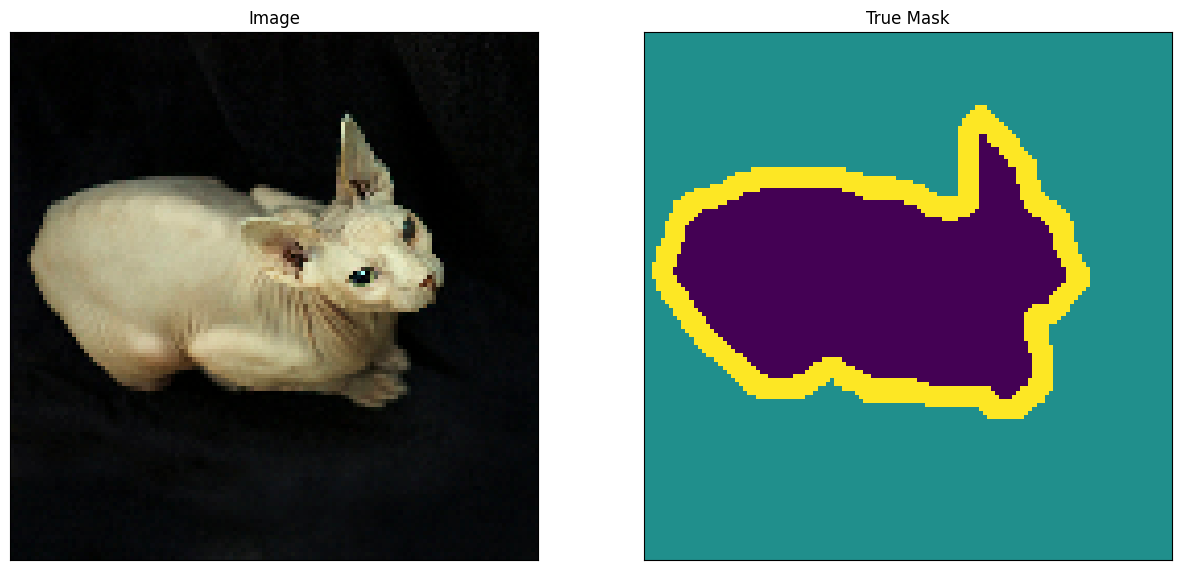

2024-06-04 09:49:32.447872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


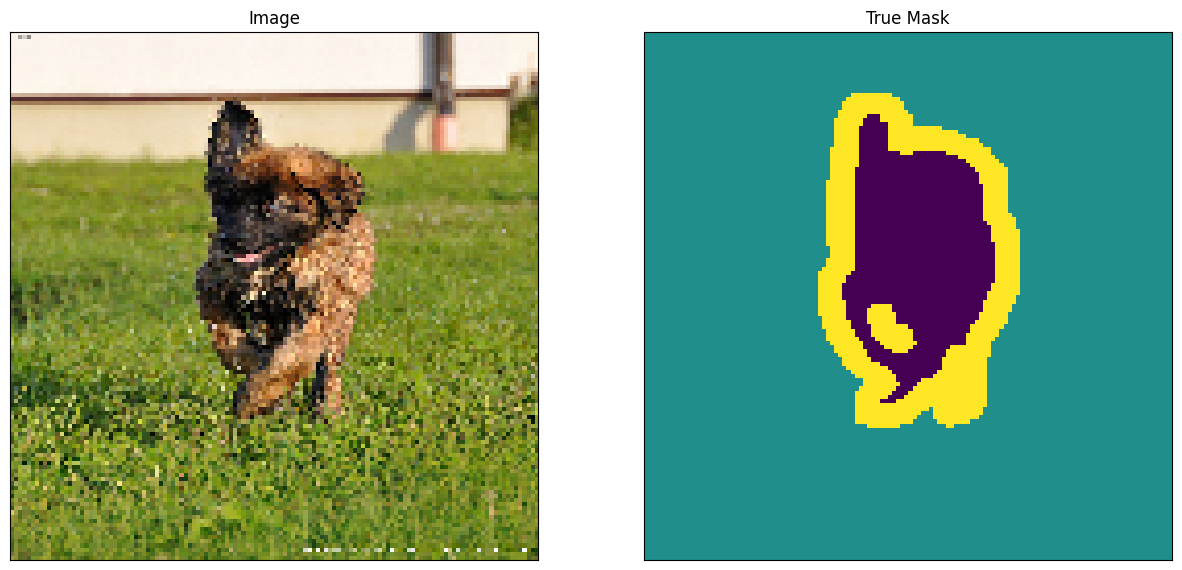

In [36]:
# display an image from the train set
show_image_from_dataset(train)

# display an image from the test set
show_image_from_dataset(test)

## Define the model

With the dataset prepared, you can now build the UNet. Here is the overall architecture as shown in class:

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

A UNet consists of an encoder (downsampler) and decoder (upsampler) with a bottleneck in between. The gray arrows correspond to the skip connections that concatenate encoder block outputs to each stage of the decoder. Let's see how to implement these starting with the encoder.

### Encoder

Like the FCN model you built in the previous lesson, the encoder here will have repeating blocks (red boxes in the figure below) so it's best to create functions for it to make the code modular. These encoder blocks will contain two Conv2D layers activated by ReLU, followed by a MaxPooling and Dropout layer. As discussed in class, each stage will have increasing number of filters and the dimensionality of the features will reduce because of the pooling layer.

<img src='https://drive.google.com/uc?export=view&id=1Gs9K3_8ZBn2_ntOtJL_-_ww4ZOgfyhrS' alt='unet'>

The encoder utilities will have three functions:

* `conv2d_block()` - to add two convolution layers and ReLU activations
* `encoder_block()` - to add pooling and dropout to the conv2d blocks. Recall that in UNet, you need to save the output of the convolution layers at each block so this function will return two values to take that into account (i.e. output of the conv block and the dropout)
* `encoder()` - to build the entire encoder. This will return the output of the last encoder block as well as the output of the previous conv blocks. These will be concatenated to the decoder blocks as you'll see later.

#### Botlneck Class

In [ ]:
# Encoder Utilities

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    pool_size (int, int) -- size of the pooling layer
    dropout (float) -- between 0 and 1. rate of the dropout layer

  Returns:
    f - the output features of the convolution block
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

### Bottleneck


A bottleneck follows the encoder block and is used to extract more features. This does not have a pooling layer so the dimensionality remains the same. You can use the `conv2d_block()` function defined earlier to implement this.

In [ ]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''

  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

### Decoder

Finally, we have the decoder which upsamples the features back to the original image size. At each upsampling level, you will take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block. This is summarized in the figure below.

<img src='https://drive.google.com/uc?export=view&id=1Ql5vdw6l88vxaHgk7VjcMc4vfyoWYx2w' alt='unet_decoder'>

In [ ]:
# Decoder Utilities

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    dropout (float) -- between 0 and 1. rate of the dropout layer

  Returns:
    c (tensor) -- output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks.

  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''

  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

### Putting it all together

You can finally build the UNet by chaining the encoder, bottleneck, and decoder. You will specify the number of output channels and in this particular set, that would be `3`. That is because there are three possible labels for each pixel: 'pet', 'background', and 'outline'.

In [ ]:
OUTPUT_CHANNELS = 3

def unet():
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)

  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

# instantiate the model
model = unet()

# see the resulting model architecture
model.summary()


## Compile and Train the model

Now, all that is left to do is to compile and train the model. The loss you will use is `sparse_categorical_crossentropy`. The reason is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class and `sparse_categorical_crossentropy` is the recommended loss for such a scenario.

In [ ]:
# configure the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# configure the training parameters and train the model

TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 10
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

# this will take around 20 minutes to run
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

You can plot the train and validation loss to see how the training went. This should show generally decreasing values per epoch.

In [ ]:
# Plot the training and validation loss
plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

## Make predictions

The model is now ready to make some predictions. You will use the test dataset you prepared earlier to feed input images that the model has not seen before. The utilities below will help in processing the test dataset and model predictions.

In [ ]:
# Prediction Utilities

def get_test_image_and_annotation_arrays():
  '''
  Unpacks the test dataset and returns the input images and segmentation masks
  '''

  ds = test_dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)

  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()

  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]

  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments


def create_mask(pred_mask):
  '''
  Creates the segmentation mask by getting the channel with the highest probability. Remember that we
  have 3 channels in the output of the UNet. For each pixel, the predicition will be the channel with the
  highest probability.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
  '''
  Feeds an image to a model and returns the predicted mask.
  '''

  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

### Compute class wise metrics

Like the previous lab, you will also want to compute the IOU and Dice Score. This is the same function you used previously.

In [ ]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(3):

    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

With all the utilities defined, you can now proceed to showing the metrics and feeding test images.


In [ ]:
# Setup the ground truth and predictions.

# get the ground truth from the test set
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

# feed the test set to th emodel to get the predicted masks
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

In [ ]:
# compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [ ]:
# show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou))

In [ ]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score))


### Show Predictions

In [ ]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 3646

# Get the prediction mask
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])

# Compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)

# Overlay the metrics with the images
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)

**That's all for this lab! In the next section, you will learn about another type of image segmentation model: Mask R-CNN for instance segmentation!**